In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

# from pulse_lib.pickle_parse import *
# from pulse_lib.phase_calibration import *

from qick import *
import Pyro4
import pickle
%pylab inline

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
out_chs = [0,1]
print(soccfg)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v2 - configured by PYNQ


In [8]:
# TODO: Make this a user-defined numpy array
# f0_start=100
# f0_step=1
# expts=100
# expts=1

f0_v = np.arange(1, 3001, 1)

# f0_v = np.arange(0,expts)*f0_step+f0_start
f0_v = soccfg.adcfreq(f0_v, gen_ch=0, ro_ch=0)

def calculate_phase(d):
    [xi,xq] = d
    x = xi +1j*xq

    # Average to improve calibration.
    xavg = np.mean(x)

    # Calculate calibration phase.
    fi = np.remainder(np.angle(xavg,deg=True)+360,360)
    return [fi, np.abs(xavg), np.std(x)]

# TODO: Redundant function?
def print_results(res):
    print("freq_i = %f MHz, "%(f0) +
         "phi_i = (%.2f, %.2f) deg, " % tuple([res[i][0] for i in range(2)]) +
         "mag = (%.2f, %.2f), " % tuple([res[i][1] for i in range(2)]) +
         "RMS = (%.2f, %.2f) ADU" % tuple([res[i][2] for i in range(2)]))
#     print("freq_i = %f MHz, phi_i = (%.2f, %.2f) deg, mag = (%.2f, %.2f), RMS = (%.2f, %.2f) ADU" %(f0,*out_array,*A,*xrms))

In [9]:
# TODO: Remove unnecessary function calls
# TODO: Move outside of notebook
class SingleFreqProgram(AveragerProgram):
    def __init__(self,soccfg, cfg):
        super().__init__(soccfg, cfg)

    def initialize(self):
        cfg=self.cfg   
        
        # configure the readout lengths and downconversion frequencies
        for ch in range(2):
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"])

        idata = 30000*np.ones(16*cfg["length"])

        for ch in self.cfg['out_ch']:
            self.declare_gen(ch=ch, nqz=1)
            self.add_pulse(ch=ch, name="measure", idata=idata)
        
        freq=soccfg.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency
        self.trigger(pins=[0], t=0) # send a pulse on pmod0_0, for scope trigger
        for ch in self.cfg['out_ch']:
            self.set_pulse_registers(ch=ch, style="arb", freq=freq, phase=cfg["res_phase"], gain=cfg["pulse_gain"], 
                                     waveform="measure", mode="periodic")

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[0,1],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        for ch in self.cfg['out_ch']:
            self.pulse(ch=ch, t=0) # play readout pulse
        self.wait_all() # control should wait until the readout is over
        self.sync_all(200)  # wait for measurement to complete

config={"out_ch":out_chs,
        "reps":1, # --Fixed
        "res_phase":soccfg.deg2reg(0), # --Fixed
        
        "length":10, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":32000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 1000, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

## ADC_D

In [10]:
# TODO: Remove near-duplicate cells
config['reps'] = 1000 # change this from 10 to 1000
config['soft_avgs'] = 1
res=[]
adc_d_offsets = {}

for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    res.append([calculate_phase(d) for d in data])
    adc_d_offsets[f0] = res[-1][0][0]
fi_v=np.array([[a[0] for a in r] for r in res]).T
soc.reset_gens()

print(adc_d_offsets)

{0.9999961853027343: 342.9584116249643, 1.9999923706054685: 248.73658987576002, 3.000009155273437: 153.91769306088872, 4.0000053405761715: 61.13579378598854, 5.000001525878906: 326.0156271541366, 5.99999771118164: 228.229874813489, 6.999993896484375: 128.60529446961925, 7.999990081787109: 27.801318139514763, 9.000006866455077: 285.89587571698104, 10.000003051757812: 183.75240847855858, 10.999999237060546: 81.2005882278479, 11.99999542236328: 338.3395190352961, 12.999991607666015: 235.23935308610544, 14.000008392333983: 131.62595910873324, 15.000004577636718: 28.171969708403083, 16.00000076293945: 284.58702862412355, 16.999996948242185: 180.89562221684477, 17.99999313354492: 77.10925868804566, 19.00000991821289: 332.929306983004, 20.000006103515624: 228.9966659055288, 21.000002288818358: 125.00655579859688, 21.999998474121092: 20.963211814638214, 22.999994659423827: 276.87946864857867, 23.99999084472656: 172.75405041452166, 25.000007629394528: 68.28048222044117, 26.000003814697262: 324.

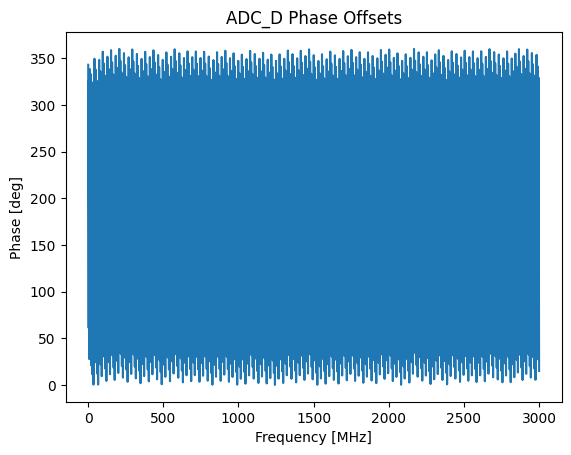

In [11]:
x, y = [], []
for key, value in adc_d_offsets.items():
    x.append(key)
    y.append(value)

plt.plot(x, y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("ADC_D Phase Offsets");

## ADC_C

In [12]:
config['reps'] = 1000 # change this from 10 to 1000
config['soft_avgs'] = 1
res=[]
adc_c_offsets = {}

for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    res.append([calculate_phase(d) for d in data])
    adc_c_offsets[f0] = res[-1][1][0]
fi_v=np.array([[a[0] for a in r] for r in res]).T
soc.reset_gens()

print(adc_c_offsets)

{0.9999961853027343: 342.685230927279, 1.9999923706054685: 248.38052250935596, 3.000009155273437: 153.79894421056906, 4.0000053405761715: 61.15315289329209, 5.000001525878906: 325.9807399343888, 5.99999771118164: 228.14478152342681, 6.999993896484375: 128.47645502134355, 7.999990081787109: 27.608488692851097, 9.000006866455077: 285.66707797654834, 10.000003051757812: 183.4830405857275, 10.999999237060546: 80.8901446636579, 11.99999542236328: 337.9881048001568, 12.999991607666015: 234.84836768687896, 14.000008392333983: 131.19823520859802, 15.000004577636718: 27.70893262625509, 16.00000076293945: 284.09033474065404, 16.999996948242185: 180.36298972921023, 17.99999313354492: 76.54620480514228, 19.00000991821289: 332.33644529513015, 20.000006103515624: 228.37627516699467, 21.000002288818358: 124.35876042294933, 21.999998474121092: 20.28979647608702, 22.999994659423827: 276.17985347312833, 23.99999084472656: 172.03089612344297, 25.000007629394528: 67.53473756694382, 26.000003814697262: 323

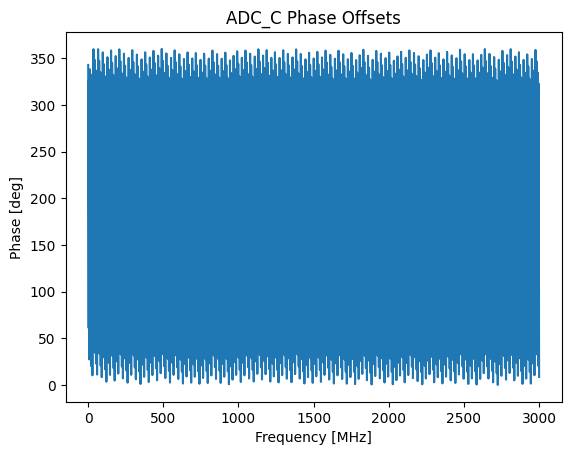

In [14]:
adc_c_x, adc_c_y = [], []
for key, value in adc_c_offsets.items():
    adc_c_x.append(key)
    adc_c_y.append(value)

plt.plot(adc_c_x,adc_c_y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("ADC_C Phase Offsets");

In [15]:
adc_offsets = {}

for freq in adc_c_offsets:
    adc_offsets[freq] = ((adc_c_offsets[freq] - adc_d_offsets[freq]) % 360) - 360

# print(adc_offsets)

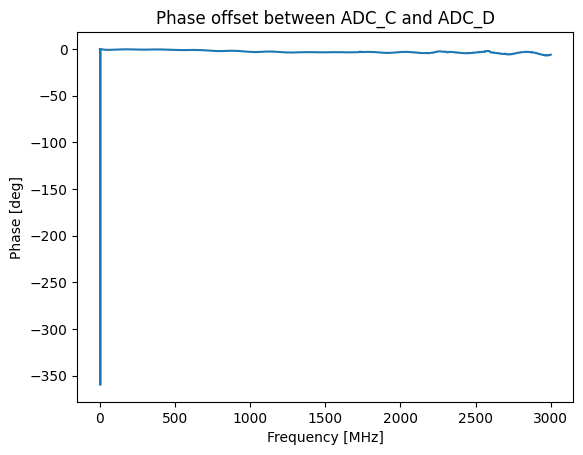

In [16]:
x,y = [], []
for key, value in adc_offsets.items():
    x.append(key)
    y.append(value)

plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase [deg]")
plt.title("Phase offset between ADC_C and ADC_D");

## Calibrate Phase

In [17]:
config['reps'] = 1000 # change this from 10 to 1000
config['soft_avgs'] = 1
res=[]
delta_phis = {}

for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(soccfg, config)
    avg_data = prog.acquire(soc, progress=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    res.append([calculate_phase(d) for d in data])
    delta_phis[f0] = [(res[-1][0][0] - res[-1][1][0] + adc_offsets[f0]) % 360, 0]
    # print_results(res[-1])
fi_v=np.array([[a[0] for a in r] for r in res]).T
soc.reset_gens()

# print(res)
# adc_c_phi = res[0][1][0]
# adc_d_phi = res[0][0][0]
# adc_d_phi_corrected = adc_d_phi + adc_offset
# delta_phi = (adc_c_phi - adc_d_phi_corrected) % 360
# print(delta_phi)
print(delta_phis)

{0.9999961853027343: [0.06749676826183304, 0], 1.9999923706054685: [0.17433926568622837, 0], 3.000009155273437: [0.8879066120016432, 0], 4.0000053405761715: [0.8801385523927365, 0], 5.000001525878906: [0.30487285223614435, 0], 5.99999771118164: [359.7282251735346, 0], 6.999993896484375: [359.2418222727543, 0], 7.999990081787109: [358.80528292469677, 0], 9.000006866455077: [358.4533524085998, 0], 10.000003051757812: [358.12804971438214, 0], 10.999999237060546: [357.82448589416003, 0], 11.99999542236328: [357.5332031900462, 0], 12.999991607666015: [357.2522731487651, 0], 14.000008392333983: [356.9810613604898, 0], 15.000004577636718: [356.7160297639739, 0], 16.00000076293945: [356.4527134729323, 0], 16.999996948242185: [356.1936648955989, 0], 17.99999313354492: [355.93626567235776, 0], 19.00000991821289: [355.68073417841697, 0], 20.000006103515624: [355.42801029266616, 0], 21.000002288818358: [355.1742792178261, 0], 21.999998474121092: [354.9211805745581, 0], 22.999994659423827: [354.668

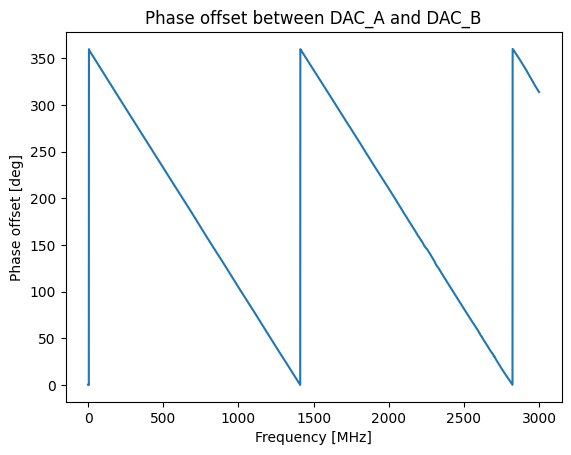

In [18]:
x,y = [], []
for key, value in delta_phis.items():
    x.append(key)
    y.append(value[0])

plt.plot(x,y)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Phase offset [deg]")
plt.title("Phase offset between DAC_A and DAC_B");

In [19]:
# to save the data
with open('pickles/calibrate_phase.pickle', 'wb') as handle:
    pickle.dump(delta_phis, handle, protocol=pickle.HIGHEST_PROTOCOL)